## Model metrics

In [54]:
from tensorboard_reducer.event_loader import EventAccumulator
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from glob import glob

In [55]:
LOG_PATH = "lightning_logs/"

input_event_dirs = sorted(glob(LOG_PATH+'*'))

joined_dirs = "\n".join(input_event_dirs)
print(f"Found {len(input_event_dirs)} runs:\n{joined_dirs}")

Found 14 runs:
lightning_logs/g_lenet_best_subset
lightning_logs/g_lenet_cut_dataset
lightning_logs/g_resnet_18_best_subset
lightning_logs/g_resnet_18_cut_dataset
lightning_logs/jiaresnet50_cut_dataset
lightning_logs/jiaresnet50_local_subset
lightning_logs/lenet_best_subset
lightning_logs/lenet_cut_dataset
lightning_logs/resnet18_cut_dataset_2
lightning_logs/resnet_18_best_subset
lightning_logs/resnet_18_cut_dataset
lightning_logs/resnet_18_local_subset
lightning_logs/resnet_50_best_subset
lightning_logs/resnet_50_cut_dataset


In [56]:
def get_metrics(model_folder,version=0):
    metrics = pd.read_csv(f"{LOG_PATH}/{model_folder}/version_{version}/metrics.csv")
    metrics = metrics.drop(['train_loss_step',	'train_acc_step',	'train_calibration_error_step'],axis=1)
    metrics = metrics.groupby(metrics['epoch']).first()
    return metrics

In [64]:
def plot_metrics(run_name,show=False,save=True):
    metrics = get_metrics(run_name)
    train_loss = metrics['train_loss_epoch']
    train_acc = metrics['train_acc_epoch']
    val_loss = metrics['val_loss']
    val_acc = metrics['val_acc']
    epoch = metrics.index

    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(221) 
    ax1.plot(epoch,train_loss,linestyle='-', c='orange')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Train Loss')

    ax2 = fig.add_subplot(222) 
    ax2.plot(epoch,val_loss,linestyle='-', c='violet')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Validation Loss')

    ax3 = fig.add_subplot(223) 
    ax3.plot(epoch,train_acc,linestyle='-', c='red')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Train Accuracy')

    ax4 = fig.add_subplot(224) 
    ax4.plot(epoch,val_acc,linestyle='-', c='green')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Validation Accuracy')
    #plt.tight_layout()
    #fig.suptitle(f"{run_name} (Loss: {test_loss:.2f}, Acc: {test_acc:.2%})")
    fig.suptitle(run_name)
    if save:
        plt.savefig(f'../Graphs/{run_name}',dpi=200)
    if show:
        plt.show()
    else:
        plt.clf()


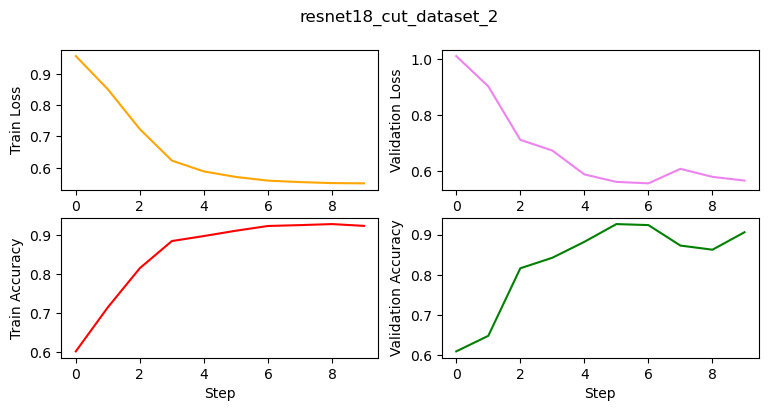

In [65]:
plot_metrics('resnet18_cut_dataset_2',show=True)

In [ ]:
for run in input_event_dirs:
    plot_metrics(run)

g_lenet_best_subset


KeyError: 'test_loss'